<a href="https://colab.research.google.com/github/AmandaGamage/object_and_cloud_detection_in_radar_surveillance_system/blob/main/Radar_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Radar and Navigation - Assignment 01**
**A.S.Gamage**

## Importing Libraries and Data Files and, Calculating Parameters

Following equations were used to calculate the parameters that are to be used throughout the project

1. $Ts=1/fr*N$

2. $fs=1/Ts$

3. No.of Samples per pulse= Sampling rate/fr

4. Downsampling rate= Sampling rate*Ts

5. No. of pulses=sample length*fr/Sampling rate

6. Length of the downsampled data set= Sample length/sampling rate

From these equations the following values were obtained.

Downsampling rate=20

No.of pulses=30

Length of downsampled dataset=900

These values were directly used for the calculations afterwards.




In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mb
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
import cv2 as cv

ds1=pd.read_csv(r'/raw_data1.csv',header=None)
ds2=pd.read_csv(r'/raw_data2.csv',header=None)
ds3=pd.read_csv(r'/raw_data3.csv',header=None)

ds1_array=np.array(list(ds1[0]))
ds2_array=np.array(list(ds2[0]))
ds3_array=np.array(list(ds3[0]))

sampleLength=18000
N=30
samplingRate=1080000
fr=1800
Ts=1/(fr*N)
fs=1/Ts #sampling frequncy
#print (fs)
sigma=1
k=1
windowSize=21
c=3*10**8
SamplesPerPulse=int(samplingRate/fr) #Samples per pulse=600

DownSamplingR=int(samplingRate*Ts)#20
numOfPulses=sampleLength*fr/samplingRate#30



rpm=12
pulsesPerDegree=int((fr*60)/(rpm*360))#25
downsampleLength=int(sampleLength/DownSamplingR)#900




## Downsampling the data
Since the downsampling rate as 20 was obtained before, this value was used to downsample this dataset. A for loop was used to do this task.

In [ ]:
def downsample(datalist):
    downsampled_data = np.array([])
    for i in range(0,sampleLength-1,DownSamplingR):
        downsampled_data=np.append(downsampled_data,datalist[i])
    downsampled_data=downsampled_data.reshape(30,30)  
    return downsampled_data


## Calculating the Threshold Value and Obtaining the Data Matrix
The following equation was used to calculate the average value. The guardband was taken as 4 for these calculations.

$(V_{avg})=\frac{(∑_{i=5}^m(Past Videos)+∑_{i=-5}^{-m}(Future Videos))}{2(m-j)}$

Here m was calculated by the following equation. (Window size=21)

$m=\frac{WindowSize-1}{2}$

Then the threshold value was calculated using $k=1.3$ and $\sigma=1$

$V_{th}=V_{avg}+k*\sigma$

Then by looping through the downsampled data matrix the $V_{th}$ values was compared with the the data value.

If $V_{th}<V$ the value in the matrix was calculated as 1. Else as 0.

In [ ]:
def matrix(ds_array,m,guardBand,k,sigma):
    MatrixArray=np.array([])
    Vth_array=np.array([])
    for i in range (30):
        #Vavg=np.array([])
        for j in range (30):
            Vavg=(sum(ds_array[int(i)-int(18000/numOfPulses)+int(j)-m-1:int(i)-int(18000/numOfPulses)+int(j)-guardBand-1])+sum(ds_array[int(i)-int(18000/numOfPulses)+int(j)+guardBand:int(i)-int(18000/numOfPulses)+int(j)+m]))/(2*(m-guardBand))
            Vth=Vavg+k*sigma
            Vth_array=np.append(Vth_array,Vth)
            if (Vth<=ds_array[i][j]):
                MatrixArray=np.append(MatrixArray,1)
            else:
                MatrixArray=np.append(MatrixArray,0)
        
    Vth_array=Vth_array.reshape(30,30)
    MatrixArray=MatrixArray.reshape(30,30)
    return MatrixArray,Vth_array


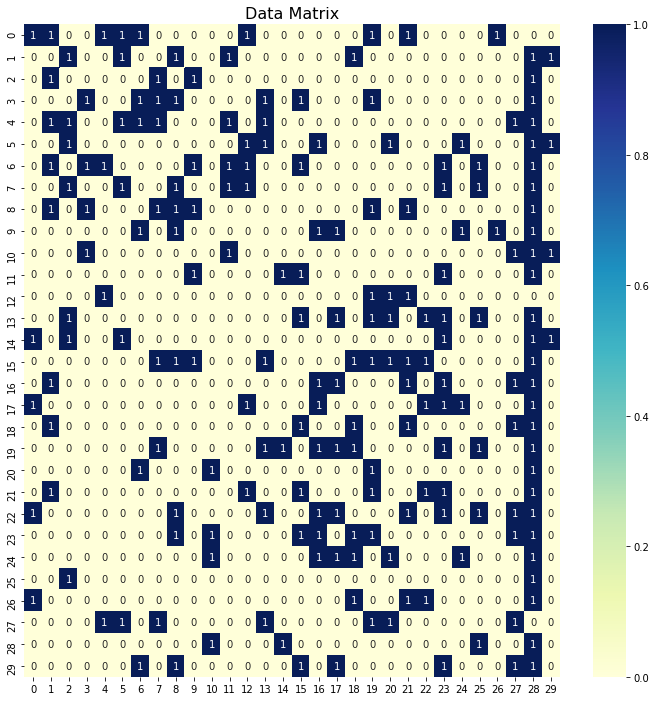

In [ ]:
m=int((windowSize-1)/2)
downsampled_matrix=downsample(ds3_array)
data_matrix,Vth_array=matrix(downsampled_matrix,m,4,k,sigma)
fig, ax = plt.subplots(figsize=(12,12))  
plt.title('Data Matrix',fontsize = 16)
ax = sns.heatmap(data_matrix,annot=True,cmap="YlGnBu")
plt.show()

## Detecting the Target
The fraction of ones compared to the length of the column was obtained. Then by taking the threshold as 0.5 the program was coded to detect an object if the fraction of ones were larger than the threshold. 

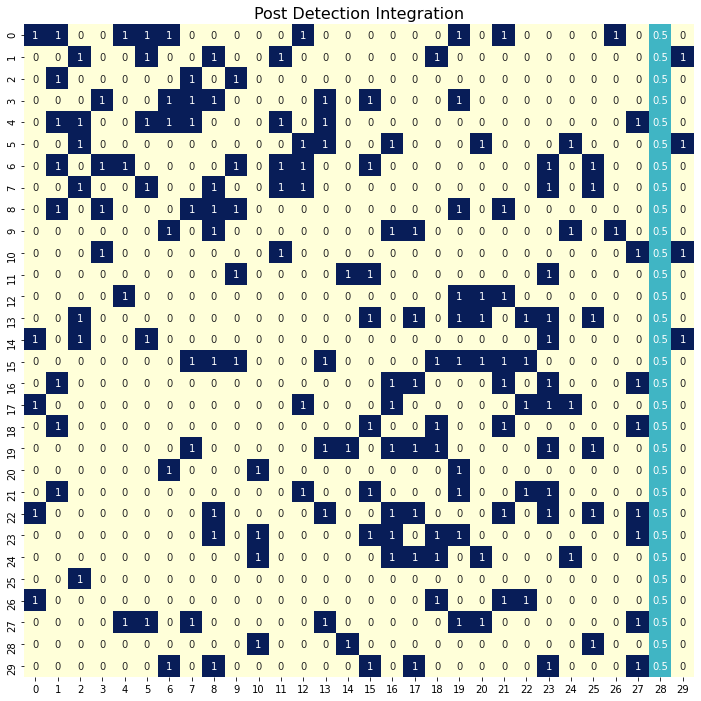

In [ ]:
def targetDetection(matrix,threshold):
    target=[]
    for i in range(30):
        onePercentage=sum(matrix[:,i])/len(matrix[:,i])
        if (onePercentage>threshold):
            target.append(i)
            matrix[:,i]=0.5
    return target,matrix
targetcolumn,new_matrix=targetDetection(data_matrix,0.5)
f, ax = plt.subplots(figsize=(12,12))
plt.title('Post Detection Integration',fontsize = 16)
ax = sns.heatmap(new_matrix, square=False,annot=True,cbar=False,cmap="YlGnBu")
    

## Cloud Detection and Noise Removal 

The following calculations were used to detect a cloud.

 If $ V_k>V_{th}$ and $V_k>6$ then $V_k=\frac{V_k}{max(matrix)}$ 

 Then if $V_k>0\Rightarrow V_k=1$ 

 else $V_k=0$

 To remove the unwanted noise at the edges of the matrix a window was used with a threshold value of 3.





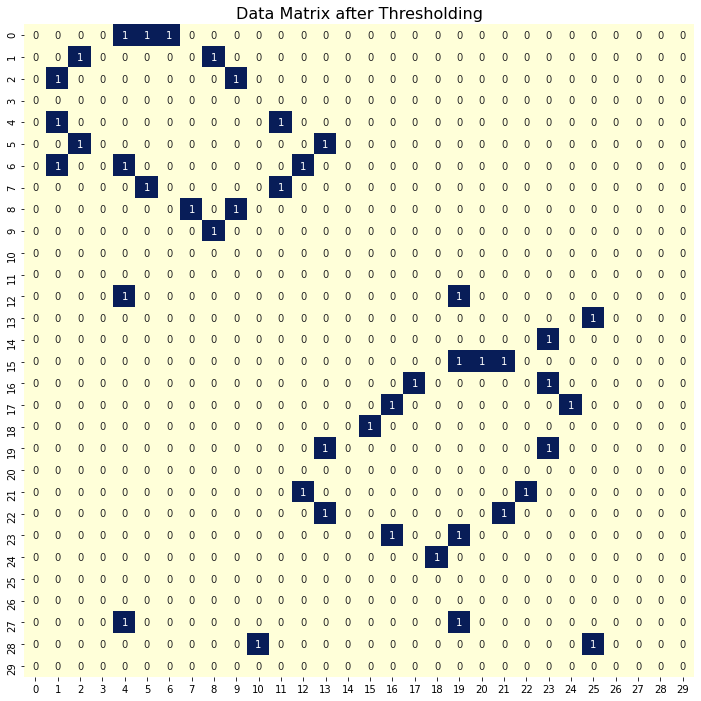

In [ ]:
def cloud_thresholding(downsampled_matrix,threshold):
    rf1=(np.where(downsampled_matrix>threshold,downsampled_matrix,0)/1).reshape(30,30)
    rf2 = np.where(rf1>6,rf1,0)
    rf3 = rf2/np.max(rf2)

    Radar_binary = np.where(rf3>0,1,0)
    Radar_binary[:,targetcolumn] = 0
    return rf1,rf2,rf3,Radar_binary

filtered1,filtered2,filtered3,radar_binary=cloud_thresholding(downsampled_matrix,Vth_array)
  
def noise1(matx):
  row0 = matx[0,:]
  row29 = matx[29,:]

  col0 = matx[:,0]
  col29 = matx[:,29]

  for i in range (0,27):
    kernel = row0 [i-2:i+3]
    if np.sum(kernel)<3:
      row0[i]=0

  for j in range (0,27):
    kernel = row29 [j-2:j+3]
    if np.sum(kernel)<3:
      row29[j]=0

  for k in range (0,27):
    kernel = col0 [k-2:k+3]
    if np.sum(kernel)<3:
      col0[k]=0
  for l in range (0,27):
    kernel = col29 [l-2:l+3]
    if np.sum(kernel)<3:
      col29[l]=0
  return matx

radar_binary=noise1(radar_binary)
f, ax = plt.subplots(figsize=(12,12))
plt.title('Data Matrix after Thresholding',fontsize = 16)
ax = sns.heatmap(radar_binary.reshape(30,30),cbar=False,cmap="YlGnBu",annot=True)
    
    

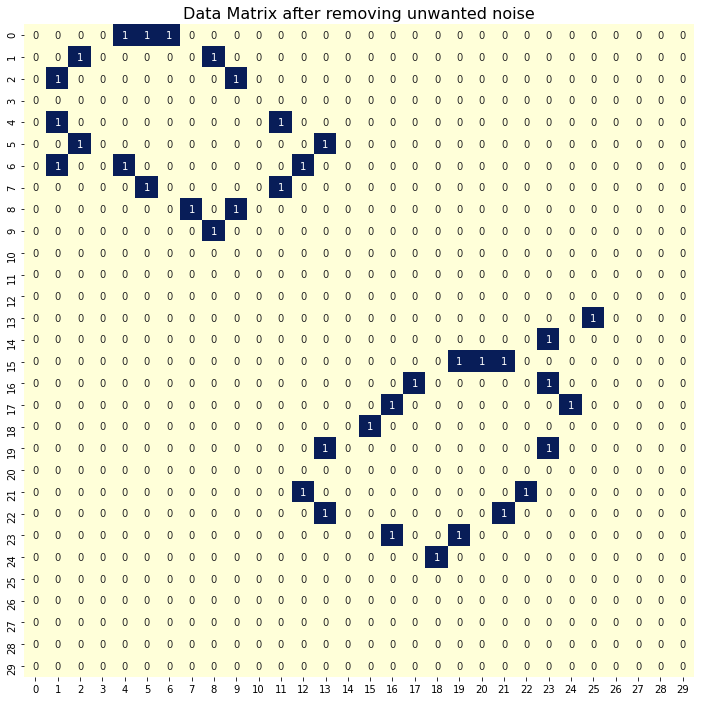

In [ ]:
def noiseFilter(matrix,threshold):
    for i in range(2,29):
        for j in range(3,28):
            window=matrix[i-2:i+2,j-3:j+3]
            if matrix[i,j]==1:
                tot=np.sum(window)
                if tot<threshold:
                    matrix[i-2:i+2,j-3:j+3]=0
                    matrix[i:min(i,i-2),j:min(j,j-3)]=0
    return matrix
noiseReduced_matrix=noiseFilter(radar_binary,2)
f, ax = plt.subplots(figsize=(12,12))
plt.title('Data Matrix after removing unwanted noise',fontsize = 16)
ax = sns.heatmap(noiseReduced_matrix.reshape(30,30),cbar=False,cmap="YlGnBu",annot=True)


    

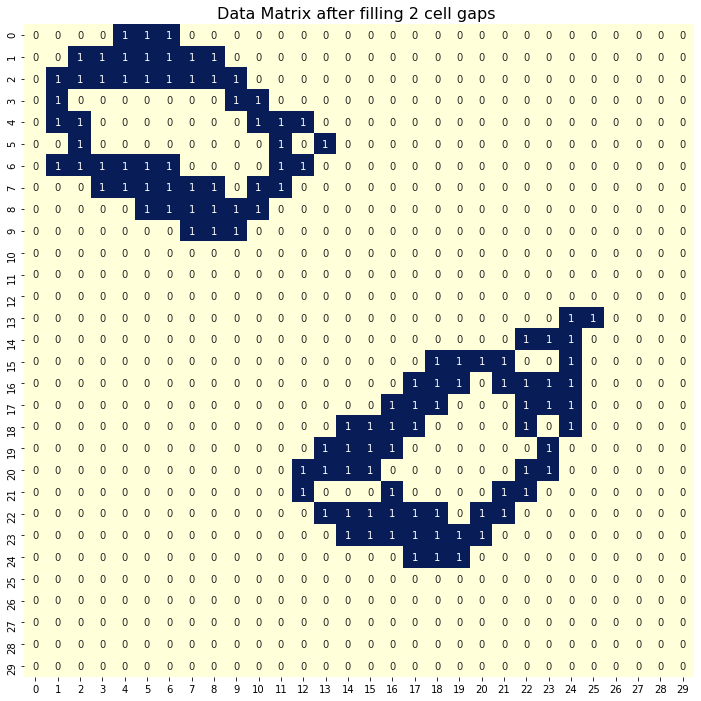

In [ ]:

def twoSpaces(window):
    for i in range(4):
        if (window[i,0]==1 and window[i,3]==1):
            window[i,1]=1
            window[i,2]=1
        elif (i<3 and window[i,0]==1 and window[i+1,3]==1):
            window[i,1]=1
            window[i+1,2]=1
        elif (i<2 and window[i,0]==1 and window[i+2,3]==1):
            window[i+1,1:2]=1
        elif(i<1 and window[i,0]==1 and window[i+3,3]==1):
            window[i+1,1]=1
            window[i+2,2]=1
    return window
def oneSpace(window):
    
    if ((window[0,0]==1 and window[2,2]==1) or (window[2,0]==1 and window[0,2]==1)or (window[0,1]==1 and window[2,1]==1)or (window[1,0]==1 and window[1,2]==1)or (window[2,0]==1 and window[1,2]==1)or (window[2,0]==1 and window[0,1]==1)):
        window[1,1]=1
    elif ((window[0,0]==1 and window[1,2]==1) or (window[0,0]==1 and window[2,1]==1)or (window[0,2]==1 and window[2,1]==1)or (window[1,0]==1 and window[0,2]==1)or (window[1,0]==1 and window[2,2]==1)or (window[0,1]==1 and window[2,2]==1)):
        window[1,1]=1
    
    return window

def drawCloud(noiseReduced_matrix):
    for i in range (27):
        for j in range (27):
            window=noiseReduced_matrix[i:i+4,j:j+4]
            newM1=(twoSpaces(window)>0)*1
            noiseReduced_matrix[i:i+4,j:j+4]=newM1
    for k in range (1,28):
        for l in range(1,28):
            window=noiseReduced_matrix[k-1:k+2,l-1:l+2]
            if np.sum(window)<5:
                newM2=(oneSpace(window)>0)*1
                noiseReduced_matrix[k-1:k+2,l-1:l+2]=newM2
    return noiseReduced_matrix
edgeCompleteMatrix=drawCloud(noiseReduced_matrix)
        
f, ax = plt.subplots(figsize=(12,12))
plt.title('Data Matrix after filling 2 cell gaps ',fontsize = 16)
ax = sns.heatmap(edgeCompleteMatrix, square=False,annot=True,cbar=False,cmap="YlGnBu")
        
   

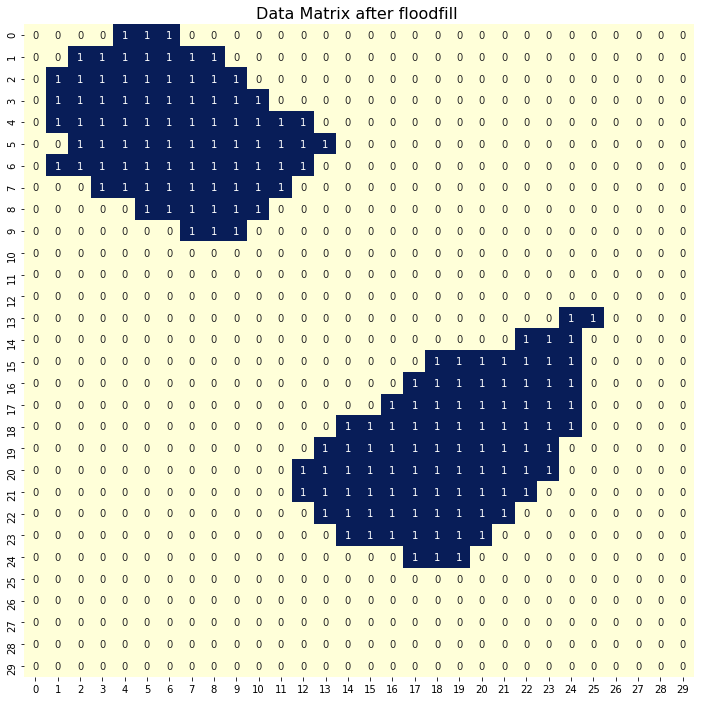

In [ ]:
data_matrix_uint=edgeCompleteMatrix.astype(np.uint8)
floodFill=cv.floodFill(data_matrix_uint, None, seedPoint=(0,0), newVal=5)

matrix_ret=floodFill[1].reshape(30,30)
dataMtrix_processed = np.where(matrix_ret==5,0,1).astype(np.float)
f, ax = plt.subplots(figsize=(12,12))
plt.title('Data Matrix after floodfill ',fontsize = 16)
ax = sns.heatmap(dataMtrix_processed, square=False,annot=True,cbar=False,cmap="YlGnBu")

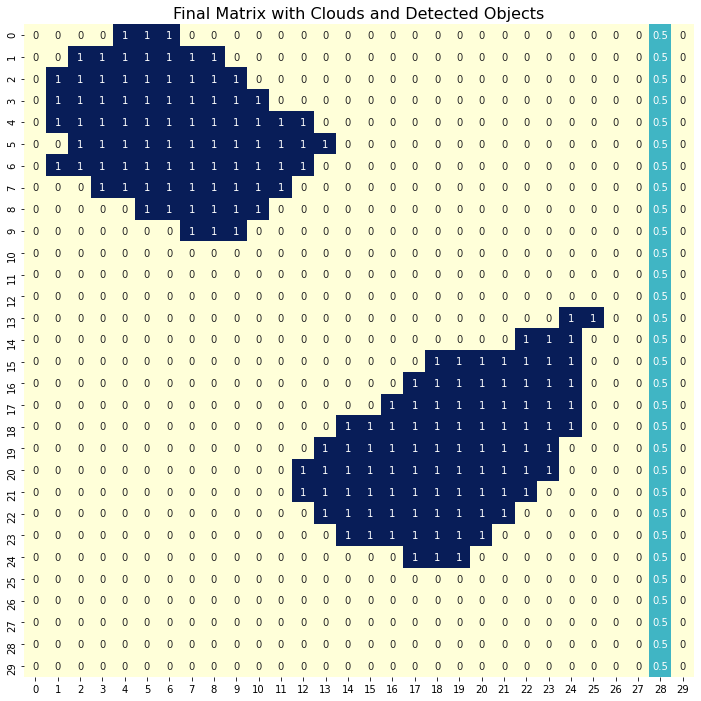

In [ ]:
dataMtrix_processed[:,targetcolumn] = 0.5

f, ax = plt.subplots(figsize=(12,12))
plt.title('Final Matrix with Clouds and Detected Objects',fontsize = 16)
ax = sns.heatmap(dataMtrix_processed, square=False,annot=True,cbar=False,cmap="YlGnBu")